# ROMMA Scraping again

Almost everyone knows that you can get time series by scraping pages.


https://www.infoclimat.fr/climatologie/normales-records/1981-2010/grenoble-lvd/valeurs/38538002.html

http://romma.fr/station_24.php?id=4&tempe=1

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import re
import time
import requests
import html


In [2]:
pp = re.compile('station_24\.php\?id=(\d+)"><b>(.*?),')
user_agent = {'User-agent': 'Mozilla/5.0'}

url = 'http://romma.fr/frame_station24.php'

r = requests.get('http://romma.fr', 
                 headers=user_agent)

stations = pp.findall(r.text)

In [3]:
code, name = zip(*stations)

In [109]:
#stations[:]

In [4]:
print(' '.join( [html.unescape(x) for x in name]) )

  BREGNIER-CORDON   VIRIAT   PONT-D'AIN   ST-ÉTIENNE-DU-BOIS   BOURG-EN-BRESSE   AMBÉRIEU-EN-BUGEY   SEYSSEL   BRIORD   LEAZ   LHOPITAL   INNIMOND   LELEX   LA VATTAY   SORGIA   MONTOISEY   SISTERON   DIGNE-LES-BAINS   ANNOT   CHAMPTERCIER   LA JAVIE   PRADS-HT-BLEONE   SELONNET   LE VERNET   SEYNE - LE GRAND PUY   SEYNE - LE FAUT   CHABANON   ST-PAUL-SUR-UBAYE   HAUT-CHABANON   GAP   LA BEAUME   EYGLIERS   LA FREISSINOUSE   ST-LEGER-LES-MELEZES   ORCIÈRES-CHAUFFAREL   ORCIÈRES-LES TOURRENGS   LES ORRES   PUY-SAINT-PIERRE   ORCIÈRES   RISTOLAS   SAINT-VÉRAN   COL DU LAUTARET   REFUGE CHAMOISSIERE   PLATEAU DE BURE   GILETTE   NICE   VENCE   TOURRETTE-LEVENS   CLANS   ST-VALLIER-DE-THIEY   CIPIÈRES   ILONSE   THORRENC   GRAVESON   MONTELIMAR   BOURG-LES-VALENCE   GRANGES-LES-BEAUMONT   AOUSTE-SUR-SYE   MONTBRISON-SUR-LEZ   CREST   ST-SORLIN-EN-VALLOIRE   DIE   LE PÈGUE   PEYRUS   RECOUBEAU   ST-JULIEN-EN-QUINT   TESSIÈRRES   ST-AGNAN-EN-VERCORS   VALOUSE   POMMEROL   BOULC   COMBE DE L'

## Extracting the data arrays

The good stuff is hiden in a frame but is easily accesible

In [53]:
def html2arrays(txt):
    def val2float(x):
        if x == '':
            return float('nan')
        return float(x)

    #I was dumping this from chrome and it  imposes fixed line widths
    #txt = re.sub('=\n','',txt)

    #json style null->nan
    #because we are going to cast string to float later
    txt = re.sub('null', 'nan', txt)

    pp = re.compile( 'var ([\w|\s]*?)array=.*?\[(.*?)\]', re.DOTALL)
    mm = pp.findall(txt)

    data = dict(mm)
    data.keys()

    fields = ['time', 'temp', 'pluie', 'intenspluie', 
              'pression', 'hum', 'rad','rafale','vent','ventdir']
    arrays = {}
    for key in fields:
       
        try:
            arrays[key] = np.array( [ val2float(x) for x in data[key].split(',')])
        except:
            print(key)
            
        #continue
        
        #this fixes holes in the time series
        if key == 'time':
            index = (arrays[key] - arrays[key][0])/600000 
            index = index.astype(np.int32)
            index[index > 4463] = 4463 # just to be safe
   
        else:
            fix = np.zeros(4464)
            fix[index] = arrays[key]
            arrays[key] = fix
            
    return arrays
        
def get_station(ref_num=6):       
    url = 'http://romma.fr/frame_station24.php' # why is this hard coded ?
    user_agent = {'User-agent': 'Mozilla/5.0'}
    
    r = requests.post(url, 
                     headers=user_agent,
                     params={"id_station":ref_num, "tempe":1})
    
    return r.text

smh = 4
voiron = 109
orange = 54
data = {}
for k in [5,109,44,4,6]: 
    tt = get_station(ref_num=k)
    meteo = html2arrays(tt)
    data[k] = meteo


In [62]:
import pickle

def hour(x):
    tt = time.localtime(x/1000)
    return tt.tm_hour + tt.tm_min/60
    
day = 24*6

# this is a bit risky it assumes there isn't a hole in the data
times = np.array([hour(x) for x in meteo['time'][:day]])


# use pickle and not json as we have np.array
fn = '20July.pkl'
data['times'] = times
with open(fn,'wb') as fp:
    pickle.dump(data,fp)

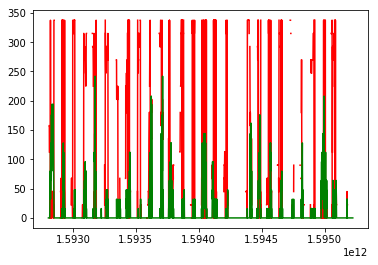

In [27]:
ww = 28*24*6
plt.plot(meteo['time'][-ww:], meteo['ventdir'][-ww:],'r')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:]*20,'g')

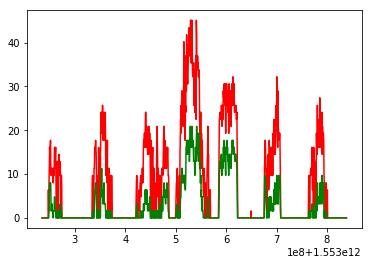

In [5]:
ww = 7*24*6
plt.plot(meteo['time'][-ww:], meteo['rafale'][-ww:],'r')
#plt.plot(tt[-ww:],np.diff(temp,n=1)[-ww:],'b')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:],'g')

    

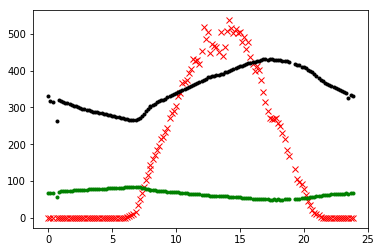

In [63]:

def tot(key='rad'):
    day = 24*6
    tot = np.zeros((day), dtype=np.float32)
    for k in range(31):
        tot += np.roll(meteo[key], k*day)[:day]
    return tot

    
# this is a bit risky it assumes there isn't a hole in the data
times = np.array([hour(x) for x in meteo['time'][:day]])


#plt.plot( times, tot(key='vent'),'b.')
plt.plot( times ,tot(key='rad')/50,'rx')
plt.plot( times ,tot(key='temp')/2,'k.')
plt.plot( times ,tot(key='hum')/28,'g.')

In [163]:
times = np.arange(144)/6


# There must be a better way

the function tot() kind of sucks  
- it's not very **numpy**.

what we really need is to 

1. reshape so that a row represents a day 
1. sum over the columns to get the average.

In [21]:
np.arange(12).reshape(3,4), np.sum(np.arange(12).reshape(3,4), axis=0)

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]), array([12, 15, 18, 21]))

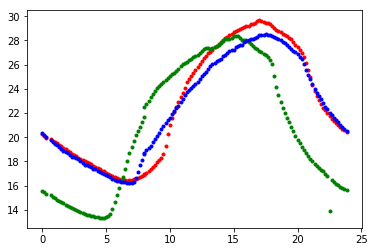

In [64]:
npts = 4464
ndays = npts//24//6

cols = [ x for x in 'rgbky']

for k in [4,5,6]:
    mm = data[k]['temp'].reshape(ndays, 24*6)/ndays
    mm[mm>1000] = 0
    plt.plot(times, np.sum(mm, axis=0), cols.pop(0) + '.')

## Let's show them all in a multiplot

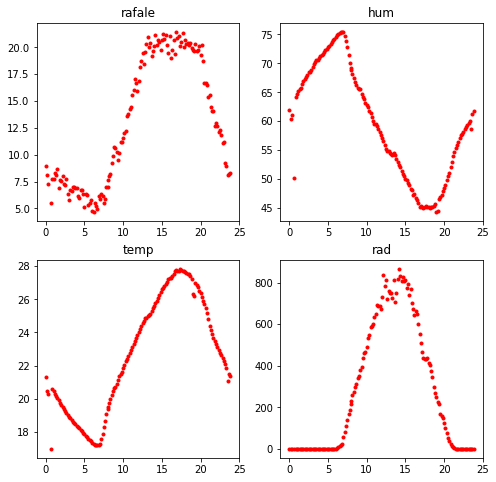

In [67]:
fig, axs = plt.subplots(2,2)
#[axi.set_axis_off() for axi in axs.ravel()]
fig.set_size_inches(8,8)

meteo = data[109]
npts = meteo['vent'].shape[0]
ndays = npts//24//6

for k, tag in enumerate(['rafale','temp','hum','rad']):
    mm = meteo[tag].reshape(ndays, 24*6)/ndays
    #not pretty but have to clean it up
    mm[np.isnan(mm)] = 0
    mm[mm > 1000] = 0 #kill the outlier

    axs[k % 2 , k // 2].plot(times, np.sum(mm, axis=0),'r.')
    axs[k % 2 , k // 2].set_title(tag)
    

## Humidity and temerature

they seem to be correlated so let's do a linear regression to see if that is actually the case.

There might be **nan**s in the arrays so mask them out before doing the regression.

In [57]:
from scipy import stats

cors = {}
for k in [4,5,6,109]:
    x = data[k]
    X = np.sum( x['temp'].reshape(ndays, 24*6)/ndays, axis=0)
    Y = np.sum( x['hum'].reshape(ndays, 24*6)/ndays, axis=0)

    mask = ~(np.isnan(X) | np.isnan(Y))
    cors[k] = stats.linregress( X[mask], Y[mask])

In [58]:
cors

{4: LinregressResult(slope=-3.0442320055130763, intercept=131.44271926967355, rvalue=-0.996712004587037, pvalue=7.095002389010271e-157, stderr=0.020767642656120577),
 5: LinregressResult(slope=-3.024257789819958, intercept=134.23652215933927, rvalue=-0.990900383632987, pvalue=1.419388307462446e-125, stderr=0.034473148164522655),
 6: LinregressResult(slope=-3.416055787997348, intercept=139.65464152388748, rvalue=-0.9973515284505515, pvalue=1.5527591350489838e-163, stderr=0.020905349566288124),
 109: LinregressResult(slope=-2.657177489510032, intercept=119.62010848711506, rvalue=-0.9683137298763871, pvalue=3.086470848040459e-86, stderr=0.05791928314013234)}

### Retiming

I have to plot the data against time otherwise it's offset
so that midnight is no longer at zero.

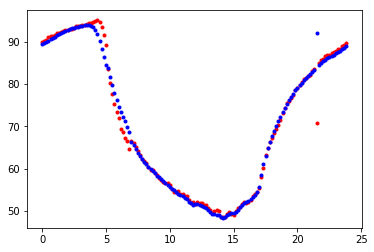

In [61]:
k = 5

vv = cors[k]
a, b = vv.slope, vv.intercept

x = data[k]
X = np.sum( x['temp'].reshape(ndays, 24*6)/ndays, axis=0)
Y = np.sum( x['hum'].reshape(ndays, 24*6)/ndays, axis=0)

plt.plot(times,Y,'r.')
#plt.plot(times,X,'g.')
plt.plot(times, a*X + b, 'b.')

## Finally calculate the time of max temperature

I checked this by hand it seems to be pretty accurate

In [171]:
numdays = 21
ts = [i for i in range(-1,-1 - numdays*24*6, -24*6)]

day_intervals = [list(zip(meteo['temp'],meteo['time']))[i:j] for i,j in  zip(ts[1:],ts)]
mx = [max(day) for day in day_intervals if day]
x,y = zip(*mx)
[time.ctime(t/1000.) for t in y]

['Sat Jul 18 18:20:00 2020',
 'Fri Jul 17 15:10:00 2020',
 'Thu Jul 16 19:00:00 2020',
 'Wed Jul 15 13:10:00 2020',
 'Tue Jul 14 17:10:00 2020',
 'Mon Jul 13 16:20:00 2020',
 'Sun Jul 12 17:30:00 2020',
 'Sat Jul 11 17:20:00 2020',
 'Fri Jul 10 17:00:00 2020',
 'Thu Jul  9 17:20:00 2020',
 'Wed Jul  8 17:20:00 2020',
 'Tue Jul  7 18:30:00 2020',
 'Mon Jul  6 16:50:00 2020',
 'Sun Jul  5 18:30:00 2020',
 'Sat Jul  4 18:30:00 2020',
 'Fri Jul  3 17:10:00 2020',
 'Thu Jul  2 17:20:00 2020',
 'Wed Jul  1 15:50:00 2020',
 'Tue Jun 30 18:40:00 2020',
 'Mon Jun 29 14:20:00 2020']

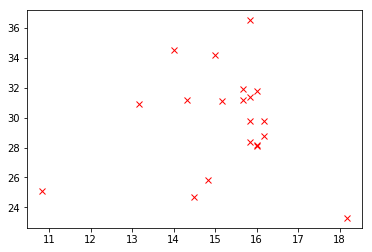

In [76]:
XS, YS = zip(*mx)
YS = [(int(y)//1000 % (24*3600)) /3600 for y in YS]
plt.plot(YS,XS, 'rx')

In [105]:
night = meteo['time'][meteo['rad'] == 0]
xx = stuff[:-1][np.diff(night)  > 600000]

NameError: name 'stuff' is not defined

In [15]:
trans = [int(y)//1000 % (24*3600) /3600 for y in xx]
trans = [ min(x,8) for x in trans ]

plt.plot(range(len(trans)),trans,'rx')

NameError: name 'xx' is not defined

In [24]:
! ./.g


[master 55a8f72] web
 4 files changed, 898 insertions(+), 872 deletions(-)
 create mode 100644 19July.json
 create mode 100644 19July.pkl
 create mode 100644 20July.pkl
 rewrite romma_again.ipynb (62%)
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 4 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 340.26 KiB | 965.00 KiB/s, done.
Total 6 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), done.
To https://github.com/macbuse/ROMMA.git
   6d7d020..55a8f72  master -> master


In [111]:
4464 - 4455

9

In [115]:
tt = get_station(ref_num=109)
meteo = html2arrays(tt)
len(meteo['time'])

4455

In [135]:
index = (meteo['time'] - meteo['time'][0])/600000 
index = index.astype(np.int32)

In [139]:
uu = np.diff(index)
sum( uu[uu > min(uu)] - min(uu) )

9

In [128]:
4464 // 24 //6

31

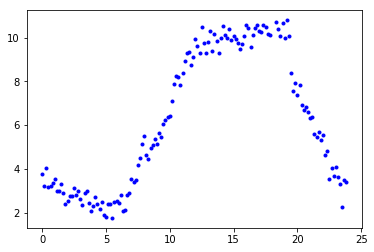

In [142]:
fix = np.zeros(4464)
fix[index] = meteo['vent']
ndays = 31
mm = fix.reshape(ndays, 24*6)/ndays
plt.plot(times, np.sum(mm, axis=0), 'b.')